<a href="https://colab.research.google.com/github/fabiano182/AMC/blob/main/CNN_AMC_Ref.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Bibliotecas:


In [2]:
from __future__ import print_function
import pickle
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

Abrindo o dataset:

In [3]:
full_dataset = pickle.load(open("/content/drive/My Drive/TCC_COLAB/Datasets/RML2016.10a_dict.dat",'rb'),encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], full_dataset.keys())))), [1,0])

digital_mods    = ['8PSK', 'BPSK', 'QAM16', 'QAM64', 'QPSK']

X = []
label = []

for mod in digital_mods:
#for mod in mods:
   for snr in snrs:
        X.append(full_dataset[(mod,snr)])
        for i in range(full_dataset[(mod,snr)].shape[0]):  label.append((mod,snr))
X = np.vstack(X)

np.random.seed(12345)
n_examples = X.shape[0]
n_train = int(n_examples * 0.9)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: digital_mods.index(label[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x:  digital_mods.index(label[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
classes = digital_mods


Reconstrução do sinal, a partir dos símbolos IQ's: 

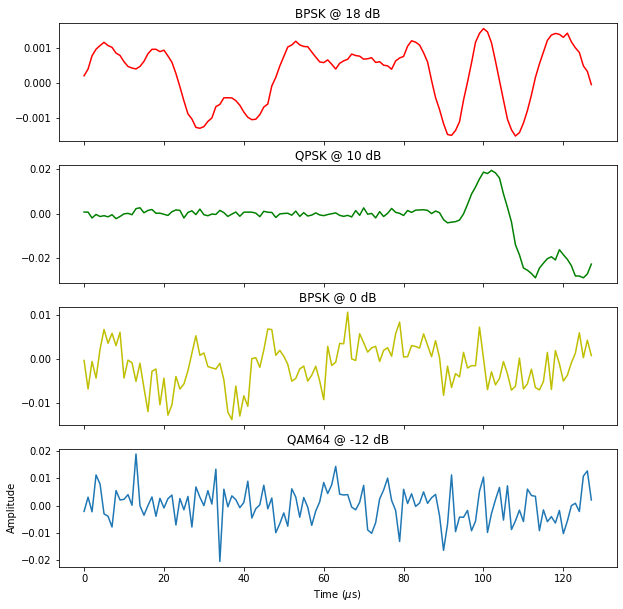

In [4]:
def Signal(s):
    I = s[0,:]
    Q = s[1,:]  
    n = len(I)    # número de amostras
    fc = 10e6     # Frequência da portadora
    return I*np.cos(2*np.pi*fc*np.arange(n)) + Q*np.sin(2*np.pi*fc*np.arange(n))


# Alguns sinais
nFigs = 4
plt.figure(figsize=(10, 10))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(Signal(full_dataset['BPSK', 18][3,:,:]), color='r');
plt.title('BPSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(Signal(full_dataset['QPSK', 10][0,:,:]), color='g');
plt.title('QPSK @ 10 dB')

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(Signal(full_dataset['QAM16', 0][0,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(Signal(full_dataset['QAM16', -10][0,:,:]));
plt.title('QAM64 @ -12 dB')

plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.ylabel('Amplitude');
plt.xlabel(r'Time ($\mu$s)');
plt.show()

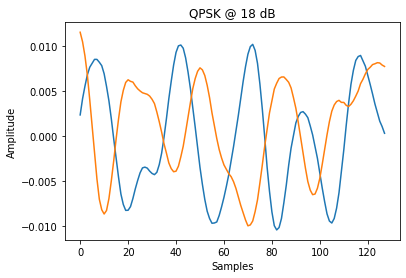

In [5]:
S = full_dataset['QAM64', 18][3,:,:]
I = S[0,:]
Q = S[1,:]

plt.plot(np.real(I))
plt.plot(np.real(Q))
plt.title('QPSK @ 18 dB')
plt.ylabel('Amplitude');
plt.xlabel(r'Samples');
plt.show()

Rede Neural Convolucional - CNN

In [6]:
def cnn1():
  dr = 0.5 # dropout rate (%)
  model = Sequential()
  model.add(Reshape(in_shp+[1], input_shape=in_shp))
  model.add(ZeroPadding2D(padding=(0,2), name="ZeroPadding_1"))
  model.add(Conv2D(128, (2, 3), activation="relu", name="Conv_1"))
  model.add(Dropout(dr, name="Dropout_1"))
  model.add(Flatten(name="Flatten_1"))
  model.add(Dense(128, activation="relu", name="Dense_1"))
  model.add(Dropout(dr, name="Dropout_2"))
  model.add(Dense(len(classes), activation="softmax", name="Output"))

  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['Accuracy'])
  model.summary()
  #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  model.save('/content/drive/My Drive/Colab Notebooks/TCC/CNN1_0.5.h5')
  return model

model_cnn1 = cnn1()
nb_epoch = 100
batch_size = 1024
filepath = '/content/drive/My Drive/Colab Notebooks/TCC/CNN1_0.5.wts.h5'

history = model_cnn1.fit(X_train,Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='auto'),
        EarlyStopping(monitor='loss', patience=5, verbose=1, mode='auto')
    ])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 ZeroPadding_1 (ZeroPadding2  (None, 2, 132, 1)        0         
 D)                                                              
                                                                 
 Conv_1 (Conv2D)             (None, 1, 130, 128)       896       
                                                                 
 Dropout_1 (Dropout)         (None, 1, 130, 128)       0         
                                                                 
 Flatten_1 (Flatten)         (None, 16640)             0         
                                                                 
 Dense_1 (Dense)             (None, 128)               2130048   
                                                        

In [42]:
def cnn3():
  dr = 0.25 # dropout rate (%)
  model = Sequential()
  model.add(Reshape(in_shp+[1], input_shape=in_shp))
  model.add(ZeroPadding2D(padding=(0,2), name="ZeroPadding_1"))
  model.add(Conv2D(128, (1, 3), activation="relu", name="Conv_1"))
  model.add(Dropout(dr, name="Dropout_1"))
  model.add(ZeroPadding2D(padding=(0,2), name="ZeroPadding_2"))
  model.add(Conv2D(64, (2, 3), activation="relu", name="Conv_2"))
  model.add(Dropout(dr, name="Dropout_2"))
  model.add(ZeroPadding2D(padding=(0,2), name="ZeroPadding_3"))
  model.add(Conv2D(16, (1, 3), activation="relu", name="Conv_3"))
  model.add(Dropout(dr, name="Dropout_3"))
  model.add(Flatten(name="Flatten_1"))
  model.add(Dense(128, activation="relu", name="Dense_1"))
  model.add(Dropout(dr, name="Dropout_4"))
  model.add(Dense(len(classes), activation="softmax", name="Output"))

  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['Accuracy'])
  model.summary()
  #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  model.save('/content/drive/My Drive/Colab Notebooks/TCC/CNN3_0.5.h5')
  return model


model_cnn3 = cnn3()
nb_epoch = 100
batch_size = 256
filepath = '/content/drive/My Drive/Colab Notebooks/TCC/CNN3_0.5.wts.h5'

history = model_cnn3.fit(X_train,Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='auto'),
        EarlyStopping(monitor='loss', patience=5, verbose=1, mode='auto')
    ])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 ZeroPadding_1 (ZeroPadding2  (None, 2, 132, 1)        0         
 D)                                                              
                                                                 
 Conv_1 (Conv2D)             (None, 2, 130, 128)       512       
                                                                 
 Dropout_1 (Dropout)         (None, 2, 130, 128)       0         
                                                                 
 ZeroPadding_2 (ZeroPadding2  (None, 2, 134, 128)      0         
 D)                                                              
                                                                 
 Conv_2 (Conv2D)             (None, 1, 132, 64)       

In [43]:
def cnn4():
  dr = 0.5 # dropout rate (%)
  model = Sequential()
  model.add(Reshape(in_shp+[1], input_shape=in_shp))
  model.add(ZeroPadding2D(padding=(0,2), name="ZeroPadding_1"))
  model.add(Conv2D(128, (1, 3), activation="relu", name="Conv_1"))
  model.add(Dropout(dr, name="Dropout_1"))
  model.add(ZeroPadding2D(padding=(0,2), name="ZeroPadding_2"))
  model.add(Conv2D(64, (2, 3), activation="relu", name="Conv_2"))
  model.add(Dropout(dr, name="Dropout_2"))
  model.add(ZeroPadding2D(padding=(0,2), name="ZeroPadding_3"))
  model.add(Conv2D(16, (1, 3), activation="relu", name="Conv_3"))
  model.add(Dropout(dr, name="Dropout_3"))
  model.add(ZeroPadding2D(padding=(0,2), name="ZeroPadding_4"))
  model.add(Conv2D(16, (1, 3), activation="relu", name="Conv_4"))
  model.add(Flatten(name="Flatten_1"))
  model.add(Dense(128, activation="relu", name="Dense_1"))
  model.add(Dropout(dr, name="Dropout_5"))
  model.add(Dense(len(classes), activation="softmax", name="Output"))

  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['Accuracy'])
  model.summary()
  #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  model.save('/content/drive/My Drive/Colab Notebooks/TCC/CNN4_0.5.h5')
  return model

model_cnn4 = cnn4()
nb_epoch = 100
batch_size = 256
filepath = '/content/drive/My Drive/Colab Notebooks/TCC/CNN4_0.5.wts.h5'

history = model_cnn4.fit(X_train,Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='auto'),
        EarlyStopping(monitor='loss', patience=5, verbose=1, mode='auto')
    ])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 ZeroPadding_1 (ZeroPadding2  (None, 2, 132, 1)        0         
 D)                                                              
                                                                 
 Conv_1 (Conv2D)             (None, 2, 130, 128)       512       
                                                                 
 Dropout_1 (Dropout)         (None, 2, 130, 128)       0         
                                                                 
 ZeroPadding_2 (ZeroPadding2  (None, 2, 134, 128)      0         
 D)                                                              
                                                                 
 Conv_2 (Conv2D)             (None, 1, 132, 64)       

Treinando a rede:

Plot da Confusion Matrix:


In [44]:
def calculate_acc(model, snrs, label):
  acc = {}
  for snr in snrs:
      test_SNRs = list(map(lambda x: label[x][1], test_idx))
      test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
      test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
  

      test_Y_i_hat = model.predict(test_X_i)

      conf = np.zeros([len(classes),len(classes)])
      confnorm = np.zeros([len(classes),len(classes)])
      for i in range(0,test_X_i.shape[0]):
          j = list(test_Y_i[i,:]).index(1)
          k = int(np.argmax(test_Y_i_hat[i,:]))
          conf[j,k] = conf[j,k] + 1

      for i in range(0,len(classes)):
          confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
      #plt.figure()
      #plot_confusion_matrix(confnorm, classes, title="Martiz de Confusão para SNR=%d"%(snr))
      
  
      cor = np.sum(np.diag(conf))
      ncor = np.sum(conf) - cor
      acc[snr] = 1.0*cor/(cor+ncor)
      
  return acc

Text(0.5, 1.0, 'Acurácia da CNN1 usando o dataset RadioML 2016.10a')

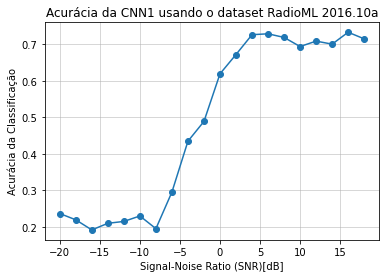

In [49]:
acc_cnn1 = calculate_acc(model_cnn1, snrs, label)
plt.plot(snrs, list(map(lambda x: acc_cnn1[x], snrs)), '-o')
plt.grid(alpha=0.5, linewidth=1)
plt.xlabel("Signal-Noise Ratio (SNR)[dB]")
plt.ylabel("Acurácia da Classificação")
plt.title("Acurácia da CNN1 usando o dataset RadioML 2016.10a")


{-20: 0.1629327902240326, -18: 0.20315581854043394, -16: 0.19886363636363635, -14: 0.21149897330595482, -12: 0.2204724409448819, -10: 0.19649805447470817, -8: 0.1845841784989858, -6: 0.20112781954887218, -4: 0.20925553319919518, -2: 0.22535211267605634, 0: 0.19611650485436893, 2: 0.1841541755888651, 4: 0.1935483870967742, 6: 0.20042643923240938, 8: 0.22336065573770492, 10: 0.18232044198895028, 12: 0.21231422505307856, 14: 0.23092369477911648, 16: 0.24520255863539445, 18: 0.21042084168336672}


Text(0.5, 1.0, 'Acurácia da CNN3 usando o dataset RadioML 2016.10a')

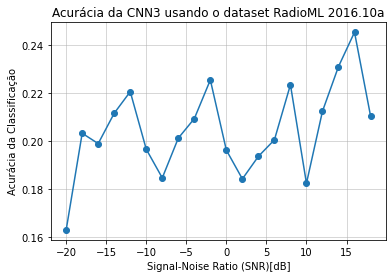

In [46]:
acc_cnn3 = calculate_acc(model_cnn3, snrs, label)
plt.plot(snrs, list(map(lambda x: acc_cnn3[x], snrs)), '-o')
plt.grid(alpha=0.5, linewidth=1)
plt.xlabel("Signal-Noise Ratio (SNR)[dB]")
plt.ylabel("Acurácia da Classificação")
plt.title("Acurácia da CNN3 usando o dataset RadioML 2016.10a")

{-20: 0.21384928716904278, -18: 0.1952662721893491, -16: 0.23106060606060605, -14: 0.18480492813141683, -12: 0.17913385826771652, -10: 0.2237354085603113, -8: 0.18052738336713997, -6: 0.20676691729323307, -4: 0.21327967806841047, -2: 0.19919517102615694, 0: 0.19029126213592232, 2: 0.2012847965738758, 4: 0.18026565464895636, 6: 0.18976545842217485, 8: 0.20901639344262296, 10: 0.20810313075506445, 12: 0.20169851380042464, 14: 0.18875502008032127, 16: 0.1791044776119403, 18: 0.19238476953907815}


Text(0.5, 1.0, 'Acurácia da CNN4 usando o dataset RadioML 2016.10a')

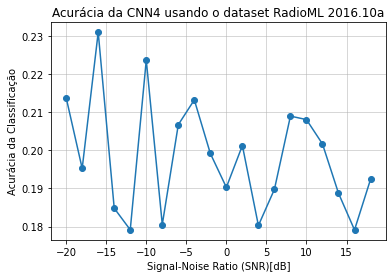

In [47]:
acc_cnn4 = calculate_acc(model_cnn4, snrs, label)
plt.plot(snrs, list(map(lambda x: acc_cnn4[x], snrs)), '-o')
plt.grid(alpha=0.5, linewidth=1)
plt.xlabel("Signal-Noise Ratio (SNR)[dB]")
plt.ylabel("Acurácia da Classificação")
plt.title("Acurácia da CNN4 usando o dataset RadioML 2016.10a")